# Data Dive Week 9: Decision Trees

This week we take a look at *decision trees*, our second type of classification model that brings deeper into the machine learning territory. We'll be using `scikit-learn` in today's exercise. 


***
![alt text](https://upload.wikimedia.org/wikipedia/commons/thumb/d/db/Titanic-Cobh-Harbour-1912.JPG/330px-Titanic-Cobh-Harbour-1912.JPG)
    
This week we'll be illustrating how decision trees work using the Titanic survivor dataset available on [Kaggle](https://www.kaggle.com/c/titanic/data). We'll look at a create variety of variables to help us learn predict whether a given passenger on the Titanic was able to survive. There is a ton out on the web (including [here](https://triangleinequality.wordpress.com/2013/09/08/basic-feature-engineering-with-the-titanic-data/)) about this dataset, as it's a popular among those just coming up to speed on machine learning classification models. Play around and use what you learn in class to join [the Kaggle competition](https://www.kaggle.com/c/titanic)!. 
***



### Data Dictionary

|Variable|Definition|Key|
| --- | --- |:---|
| survival | Survival | 0 = No, 1 = Yes |
| pclass	| Ticket class	| 1 = 1st, 2 = 2nd, 3 = 3rd |
| sex	| Sex | | 	
| Age | Age in years | | 	
| sibsp	| # of siblings / spouses aboard the Titanic | 	| 
| parch	| # of parents / children aboard the Titanic | | 
| ticket | Ticket number | | 
| fare	| Passenger fare | 	| 
| cabin	| Cabin number| 	| 
| embarked | Port of Embarkation	| C = Cherbourg (France), Q = Queenstown (Ireland), S = Southampton (England) | 

In [40]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score


# Used for visualizing trees, but not strictly necessary
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

%matplotlib inline

# Load and summarize data

In [41]:
df = pd.read_csv('https://grantmlong.com/data/titanic.csv', index_col='PassengerId')

In [42]:
df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [43]:
df.Survived.describe()

count    891.000000
mean       0.383838
std        0.486592
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        1.000000
Name: Survived, dtype: float64

##### Summarize survival by age.

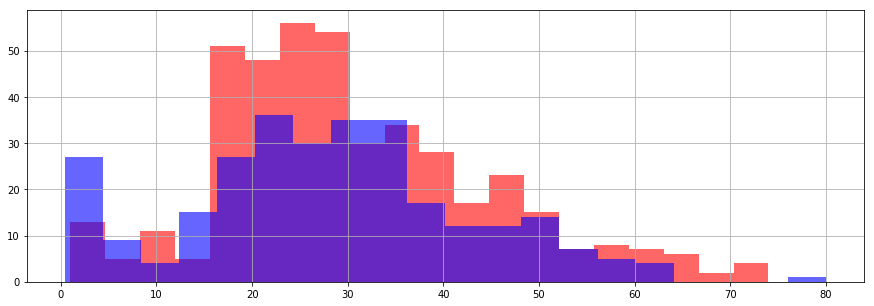

In [44]:
df.loc[(df.Survived==0), 'Age'].hist(bins=20, alpha=.6, color='red', figsize=[15, 5])
df.loc[(df.Survived==1), 'Age'].hist(bins=20, alpha=.6, color='blue')


##### Summarize survival by sex.

In [45]:
df[['Sex', 'Survived']].groupby('Sex').agg(['mean', 'count'])

Survived      
            mean count
Sex                   
female  0.742038   314
male    0.188908   577

##### Find and Count Nulls

In [56]:
df.isna().sum()

Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin        687
Embarked       2
emb_S          0
emb_C          0
emb_Q          0
is_male        0
has_cabin      0
dtype: int64

##### TODO: Summarize by Pclass, point of embarkment

# Data Cleaning and Feature Engineering

Sadly `sci-kit learn` will only let use numeric or boolean variables to train our decision tree, so let's transform some of our variables to address that. 
* Create booleans for each of the Embarkment points.
* Create a boolean for is_male. 
* Create a boolean for whether someone has a cabin. 
* **TODO, time permitting:** create identifiers for passengers in A, B, C, and D cabins

Moreover, some of our ages are missing, so let's enter the missing values as 100 for now. 

In [59]:
# Embarkment booleans
for k in df.Embarked.unique():
    if type(k)==str:
        df['emb_' + k] = (df.Embarked==k)*1

# Sex boolean
df['is_male'] = (df.Sex=='male')*1

# Has cabin boolean
df.loc[:, 'has_cabin'] = 0
df.loc[df.Cabin.isna(), 'has_cabin'] = 1

# Age fill
df.loc[df.Age.isna(), 'Age'] = 100

print(list(df))
df.head()

['Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'emb_S', 'emb_C', 'emb_Q', 'is_male', 'has_cabin']


,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,emb_S,emb_C,emb_Q,is_male,has_cabin
PassengerId,,,,,,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,1,0,0,1,1
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,0,1,0,0,0
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1,0,0,0,1
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,1,0,0,0,0
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,1,0,0,1,1


##### Let's assign a list of our clean and model ready features to a list so we can call them easily while training our model. 

In [65]:
features = ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 
            'emb_S', 'emb_C', 'emb_Q', 'is_male', 'has_cabin']

valid = df[features].notna().all(axis=1)
print(len(df), sum(valid))


891 891


# Building a Decision Tree

Now that we have variables in good shape, we can start modeling. Let's train a simple tree and see how it performs.   


In [68]:
dtree=DecisionTreeClassifier(
    criterion='entropy', 
    max_depth=3
)

dtree.fit(df[features],
          df['Survived'])

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

#### Visualize the tree. *Note: there's a strong chance this will not work if you do not have `graphviz` installed.* 
For more on visualizing decision trees see [here](https://chrisalbon.com/machine_learning/trees_and_forests/visualize_a_decision_tree/), and for more on installing graphviz see [here](https://graphviz.gitlab.io). To install `graphviz` on my Macbook Air, I used `brew install graphviz`.

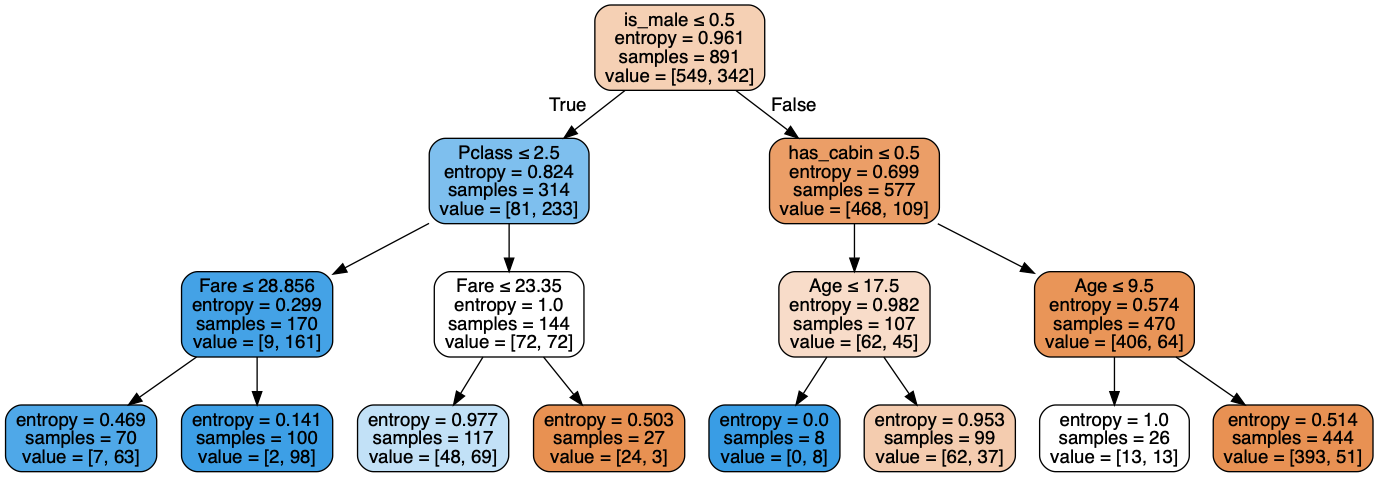

In [74]:
dot_data = StringIO()
export_graphviz(dtree, 
                out_file=dot_data,  
                filled=True, 
                rounded=True,
                feature_names=features,
                special_characters=True
               )
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())